In [21]:
import pandas as pd
import numpy as np
import spacy
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from collections import defaultdict

In [ ]:
Supplementary Figure S1

## Tasks

In [22]:
jobzone = pd.read_csv('../data/raw/All_Job_Zones.csv')

In [23]:
occupations = pd.read_csv('../data/raw/db_24_3_text/Occupation Level Metadata.txt', sep='\t')

In [24]:
occupations_naics_sector = occupations[occupations['Item'] == 'NAICS Sector']


In [27]:
task_ratings = pd.read_csv('../data/raw/db_24_3_text/Task Ratings.txt', sep='\t').query('`Scale ID` == "IM"')
task_statements = pd.read_csv('../data/raw/db_24_3_text/Task Statements.txt', sep='\t')

In [31]:
jobs = pd.read_csv('../data/raw/db_24_3_text/Occupation Data.txt', sep='\t')
jobs['SOC Code'] = jobs['O*NET-SOC Code'].str[:7]
tasks = pd.merge(
    task_ratings,
    task_statements[['O*NET-SOC Code', 'Task ID', 'Task']],
    how='left',
    on=['O*NET-SOC Code', 'Task ID']
)

In [6]:
task_embedding = np.load('../data/processed/Embeddings/task_embeddings_t5-xl.npy')

### Disruptive and Consolidating Tasks

In [7]:
disruptive_tasks = pd.read_csv('../data/processed/ClassifiedTasks/disruptive_tasks.csv', on_bad_lines= 'skip')
consolidating_tasks = pd.read_csv('../data/processed/ClassifiedTasks/consolidating_tasks.csv', on_bad_lines= 'skip')


In [8]:
tasks = pd.read_csv('../data/processed/tasks_matched_with_ai_patent_keywords_alicpc.csv')
quantile_threshold = tasks['patents_cosine_similarity'].quantile(0.9)
tasks_notexposedai = tasks[tasks['patents_cosine_similarity']<quantile_threshold]
tasks_exposedai = tasks[tasks['patents_cosine_similarity']>quantile_threshold]

In [9]:
def attaching_sector(task_id, task_df):

    soc_code = task_df[task_df['Task ID']==task_id]['O*NET-SOC Code']
    # print("Job title",jobs[jobs['O*NET-SOC Code']==soc_code]['Title'])
    occupations_naics_sector = occupations[occupations['Item'] == 'NAICS Sector']
    # print("Community size", len([i for i in partition_disruptive if partition_disruptive[i]==com_id]))
    soc_code = soc_code.item()
    # soc_code = soc_code[:7] + '.00'
    
    value = occupations_naics_sector[(occupations_naics_sector['O*NET-SOC Code'] == soc_code) & (occupations_naics_sector['Percent'] > 50) ]['Response']
    return list(value)
        

In [10]:
def building_network(id_pandas, threshold):
    indices = id_pandas['index'] # embedding index
    
    temp_embeddings = task_embedding[indices]

# Calculate the cosine similarity matrix
    similarity_matrix = cosine_similarity(temp_embeddings)
    

    upper_triangle_indices = np.triu_indices_from(cosine_similarity(task_embedding), k=1)
    similarity_values = cosine_similarity(task_embedding)[upper_triangle_indices]
    threshold_cosine = np.percentile(similarity_values, threshold)  # 75th percentile
    
    
    # Create a graph
    G = nx.Graph()
    
    # Add edges to the graph based on cosine similarity
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):  # To ensure each pair is added only once
            if similarity_matrix[i][j] > threshold_cosine:  # Only consider relatively strong similarities
                G.add_edge(i, j, weight=similarity_matrix[i][j])
                
    index_to_task = id_pandas['Task'].reset_index().to_dict()['Task'] # 
    index_to_index = id_pandas['index'].reset_index().to_dict()['index'] # node: embedding index
    
    # Map indices to task descriptions
    # Apply Louvain community detection
    return G, index_to_task,index_to_index
    

In [11]:
def finding_representative(G, partition, index_to_task, index_to_index, fixed_total_number):
    representatives = {}
    for node in G.nodes():
        com_id = partition[node]  # Get the community ID for the node
    
        # Compute the intra-community degree of the node
        # Only count edges where both nodes are in the same community
        intra_community_degree = sum(1 for neighbor in G.neighbors(node) if partition[neighbor] == com_id)
    
        # If the community is not yet in the dictionary or if this node has a higher intra-community degree
        # than the current representative, update the representative
        if com_id not in representatives or intra_community_degree > representatives[com_id][1]:
            representatives[com_id] = (node, intra_community_degree)

    # Output the representative tasks
    for com_id, (node, degree) in representatives.items():
        print("========"*10)
        print(node)
        print(f"Community {com_id}: '{index_to_task[node]}' with degree {degree}")
        index_value = index_to_index[node]
        soc_code = tasks.loc[index_value]['O*NET-SOC Code']
        print("Job title",jobs[jobs['O*NET-SOC Code']==soc_code]['Title'])
        occupations_naics_sector = occupations[occupations['Item'] == 'NAICS Sector']
        print("Community size", len([i for i in partition if partition[i]==com_id]))
        print(jobzone[(jobzone['Code'] == soc_code) ]['Job Zone'])
        print(occupations_naics_sector[(occupations_naics_sector['O*NET-SOC Code'] == soc_code) & (occupations_naics_sector['Percent'] > 50) ]['Response'])
        


In [12]:
def finding_representative(G, partition, index_to_task, index_to_index, fixed_total_number,save_dic):


    # Dictionary to hold all nodes by their community with their degrees
    community_nodes = defaultdict(list)

    # Iterate over all nodes to gather intra-community degrees
    for node in G.nodes():
        com_id = partition[node]
        intra_community_degree = sum(1 for neighbor in G.neighbors(node) if partition[neighbor] == com_id)
        community_nodes[com_id].append((node, intra_community_degree))

    # Determine the total number of nodes and calculate proportions for each community
    total_nodes = sum(len(nodes) for nodes in community_nodes.values())
    representatives = {}

    # Select proportional representatives from each community
    for com_id, nodes in community_nodes.items():
        # Calculate the number of representatives for this community
        num_representatives = int(round(len(nodes) / total_nodes * fixed_total_number))
        
        # Sort nodes by intra-community degree to get top representatives
        top_representatives = sorted(nodes, key=lambda x: x[1], reverse=True)[:num_representatives]
        representatives[com_id] = top_representatives

    # Output the representative tasks


    rows = []


    for com_id, nodes in representatives.items():
        print("========"*10)
        for node, degree in nodes:
            print(f"Community {com_id}: '{index_to_task[node]}' with degree {degree}")
            task_title = index_to_task[node]
            
            index_value = index_to_index[node]
            soc_code = tasks.loc[index_value]['O*NET-SOC Code']
            task_id = tasks.loc[index_value]['Task ID']
            print("Job title", jobs[jobs['O*NET-SOC Code'] == soc_code]['Title'])
            job_title = jobs[jobs['O*NET-SOC Code'] == soc_code]['Title'].values[0] if not jobs[jobs['O*NET-SOC Code'] == soc_code].empty else "Unavailable"
            
            print("Community size", len([i for i in partition if partition[i] == com_id]))
            job_zone_info = jobzone[jobzone['Code'] == soc_code]['Job Zone']
            print("Job zone", job_zone_info)
            naics_info = occupations[occupations['Item'] == 'NAICS Sector']
            relevant_naics_info = naics_info[(naics_info['O*NET-SOC Code'] == soc_code) & (naics_info['Percent'] > 50)]
            naics_response = ', '.join(relevant_naics_info['Response'].values)
            print("NAICS Sector involvement:", relevant_naics_info['Response'])
            
            rows.append([com_id, len([i for i in partition if partition[i] == com_id]),task_title, degree, naics_response, job_title,task_id])
            print("--------"*10)

    result_df = pd.DataFrame(rows, columns=['Community_Number','Community_Size', 'Task_Title', 'Degree', 'Sector', 'Job Title','Task ID'])

    # Save to CSV
    result_df.to_csv(save_dic, index=False)
    print("Saved representative task data to", save_dic)



## Building Network of Disruptive patents that tasks are exposed to

In [13]:
disruptive_tasks['index'] = disruptive_tasks['Unnamed: 0']

In [14]:
G_disruptive,disruptive_index_to_task,disruptive_index_to_index = building_network(disruptive_tasks,95)

In [15]:
partition_disruptive = community_louvain.best_partition(G_disruptive,resolution=1)
modularity_score = community_louvain.modularity(partition_disruptive, G_disruptive)

In [16]:
set(partition_disruptive.values())

{0, 1, 2, 3, 4, 5}

In [17]:
SAVE_DISRUPTIVE_REPRESENTATIVE = ' '

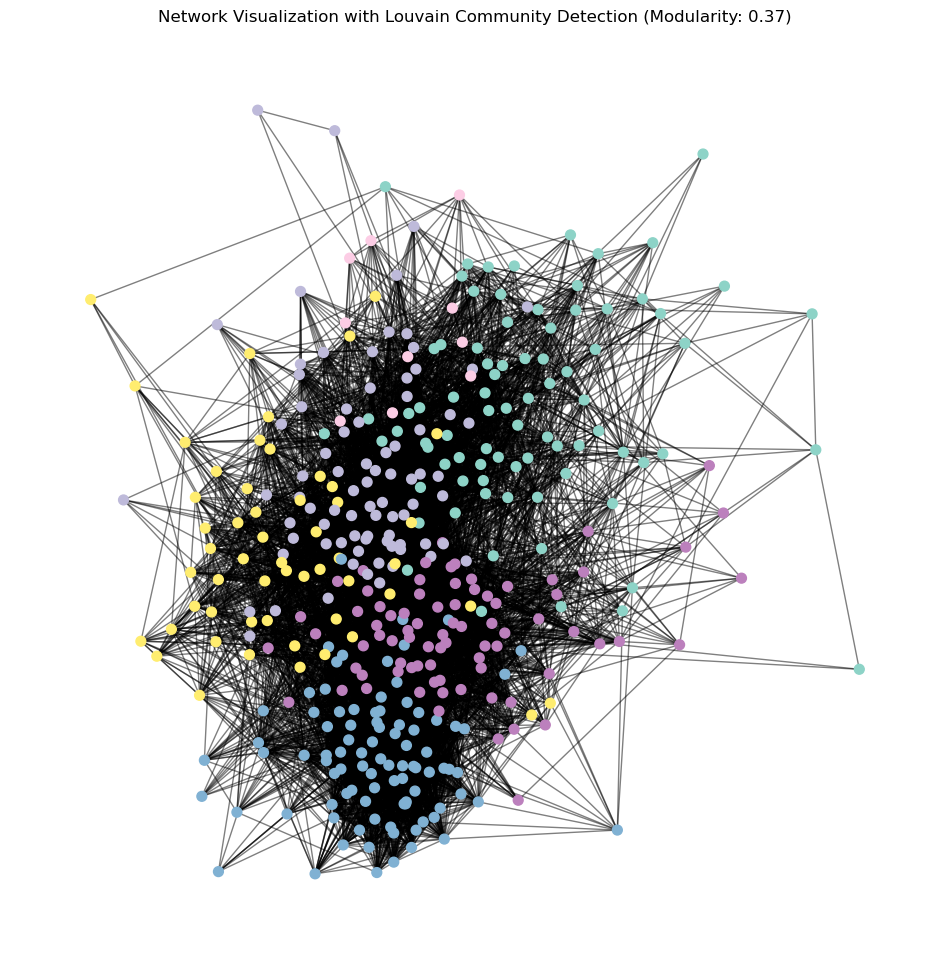

In [19]:


# Assign colors to each community
community_colors = [partition_disruptive[node] for node in G_disruptive.nodes()]

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_disruptive)  # Layout for better visualization

nx.draw_networkx_nodes(G_disruptive, pos, node_color=community_colors, cmap=plt.cm.Set3, node_size=50,label=False)
nx.draw_networkx_edges(G_disruptive, pos, alpha=0.5)

# Optionally, add labels to nodes
# nx.draw_networkx_labels(G_disruptive, pos,  font_size=8)

plt.title(f"Network Visualization with Louvain Community Detection (Modularity: {modularity_score:.2f})")
# plt.savefig('../../results/figures/disruptive_louvain.pdf')
plt.axis('off')
plt.show()


In [32]:
finding_representative(G_disruptive, partition_disruptive, disruptive_index_to_task, disruptive_index_to_index,20, SAVE_DISRUPTIVE_REPRESENTATIVE )

Community 0: 'Schedule or dispatch workers, work crews, equipment, or service vehicles to appropriate locations, according to customer requests, specifications, or needs, using radios or telephones.' with degree 49
Job title 732    Dispatchers, Except Police, Fire, and Ambulance
Name: Title, dtype: object
Community size 82
Job zone 240    2
Name: Job Zone, dtype: int64
NAICS Sector involvement: 21654    Transportation and warehousing
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Schedule or monitor air or surface pickup, delivery, or distribution of products or materials.' with degree 47
Job title 24    Storage and Distribution Managers
Name: Title, dtype: object
Community size 82
Job zone Series([], Name: Job Zone, dtype: int64)
NAICS Sector involvement: Series([], Name: Response, dtype: object)
--------------------------------------------------------------------------------
Community 0: 'Develop storage an

## Building Network of Consolidating patents that tasks are exposed to

In [28]:
consolidating_tasks['index'] = consolidating_tasks['Unnamed: 0']

In [29]:
G_consolidating,consolidating_index_to_task,consolidating_index_to_index  = building_network(consolidating_tasks,95)

In [39]:
set(partition_consolidating.values())

{0, 1, 2, 3, 4}

In [30]:
partition_consolidating = community_louvain.best_partition(G_consolidating,resolution=1)
modularity_score = community_louvain.modularity(partition_consolidating, G_consolidating)

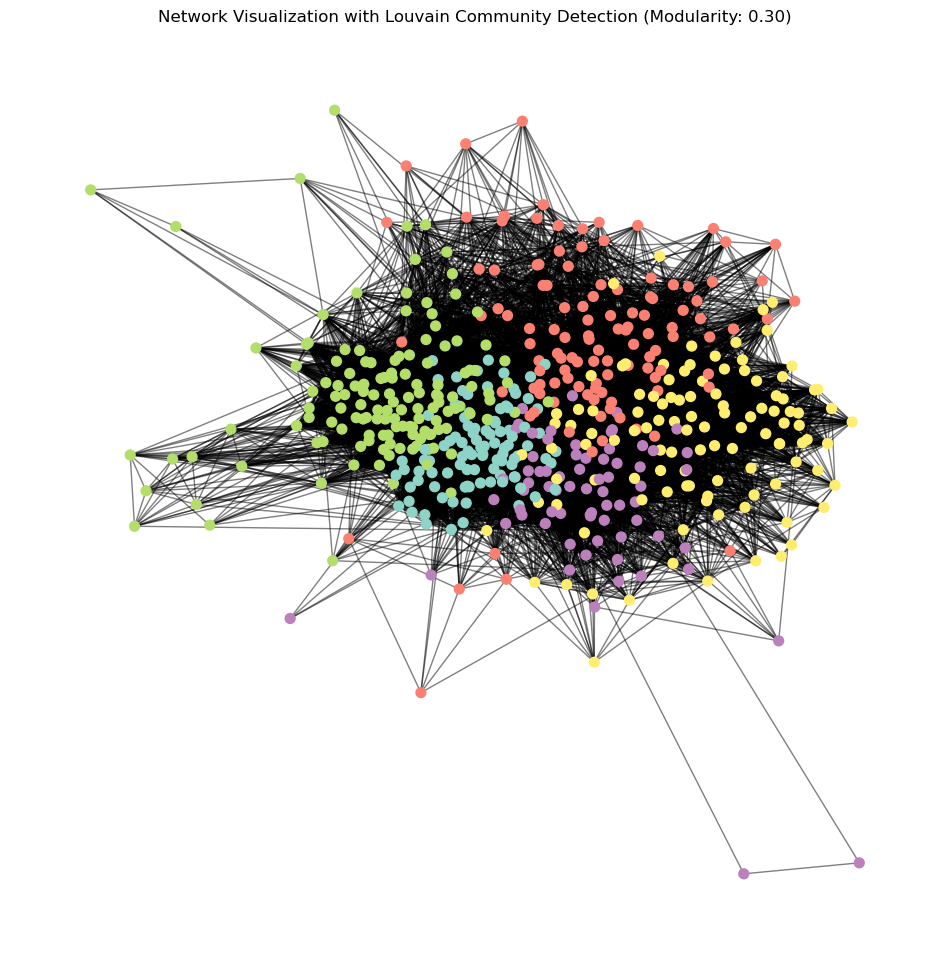

In [32]:


# Assign colors to each community
community_colors = [partition_consolidating[node] for node in G_consolidating.nodes()]

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_consolidating)  # Layout for better visualization

nx.draw_networkx_nodes(G_consolidating, pos, node_color=community_colors, cmap=plt.cm.Set3, node_size=50,label=False)
nx.draw_networkx_edges(G_consolidating, pos, alpha=0.5)

# Optionally, add labels to nodes
# nx.draw_networkx_labels(G_disruptive, pos,  font_size=8)

plt.title(f"Network Visualization with Louvain Community Detection (Modularity: {modularity_score:.2f})")
plt.savefig('../../results/figures/consolidating_louvain.pdf')
plt.axis('off')
plt.show()


In [76]:
# SAVE_CONSOLIDATING_REPRESENTATIVE = '/10TBdrive/MJ/Disruptive_Impact_Job/data/Playground07062024/derived/Representative_Task_Semantic/consolidating_representative_tasks.csv'

In [77]:
finding_representative(G_consolidating, partition_consolidating, consolidating_index_to_task, consolidating_index_to_index,28,SAVE_CONSOLIDATING_REPRESENTATIVE)

Community 0: 'Observe air and temperature gauges or metal color and fluidity, and turn fuel valves or adjust controls to maintain required temperatures.' with degree 50
Job title 939    Metal-Refining Furnace Operators and Tenders
Name: Title, dtype: object
Community size 53
Job zone 556    2
Name: Job Zone, dtype: int64
NAICS Sector involvement: 29351    Manufacturing
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Adjust and maintain industrial machinery, using control and regulating devices.' with degree 49
Job title 872    Mobile Heavy Equipment Mechanics, Except Engines
Name: Title, dtype: object
Community size 53
Job zone 566    3
Name: Job Zone, dtype: int64
NAICS Sector involvement: 26801    Construction
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Observe temperature, humidity, pressure gauges, and product samples and adju

## Building Network of Tasks Exposed to AI patents that tasks are exposed to

In [15]:
tasks_exposedai['index'] = tasks_exposedai['Unnamed: 0']

/tmp/ipykernel_31804/3683724161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['index'] = tasks_exposedai['Unnamed: 0']


In [16]:
G_exposed,tasks_exposed_index_to_task,tasks_exposed_index_to_index = building_network(tasks_exposedai,95)

In [17]:
partition_exposed = community_louvain.best_partition(G_exposed,resolution=1)
modularity_score = community_louvain.modularity(partition_exposed, G_exposed)

In [67]:
SAVE_EXPOSED_TASKS_REPRESENTATIVE = '/10TBdrive/MJ/Disruptive_Impact_Job/data/Playground07062024/derived/Representative_Task_Semantic/exposed_ai_representative_tasks.csv'

In [78]:
finding_representative(G_exposed, partition_exposed ,tasks_exposed_index_to_task, tasks_exposed_index_to_index,30, SAVE_EXPOSED_TASKS_REPRESENTATIVE)

Community 2: 'Load, unload, or identify building materials, machinery, or tools, distributing them to the appropriate locations, according to project plans or specifications.' with degree 462
Job title 798    Construction Laborers
Name: Title, dtype: object
Community size 516
Job zone 178    2
Name: Job Zone, dtype: int64
NAICS Sector involvement: 24071    Construction
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 2: 'Manually or mechanically load or unload materials from pallets, skids, platforms, cars, lifting devices, or other transport vehicles.' with degree 461
Job title 1078    Industrial Truck and Tractor Operators
Name: Title, dtype: object
Community size 516
Job zone 455    2
Name: Job Zone, dtype: int64
NAICS Sector involvement: 34382    Manufacturing
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 2: 'Open valves, gates, or chute

## Building Network of Tasks Not Exposed to AI patents that tasks are exposed to

In [18]:
tasks_notexposedai['index'] = tasks_notexposedai['Unnamed: 0']

/tmp/ipykernel_31804/3744923233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_notexposedai['index'] = tasks_notexposedai['Unnamed: 0']


In [19]:
G_not_exposed,tasks_not_exposed_index_to_task,tasks_not_exposed_index_to_index = building_network(tasks_notexposedai,95)

In [20]:
partition_notexposed = community_louvain.best_partition(G_not_exposed,resolution=1)
modularity_score = community_louvain.modularity(partition_notexposed, G_not_exposed)

In [38]:
set(partition_notexposed.values())

{0, 1, 2, 3, 4, 5}

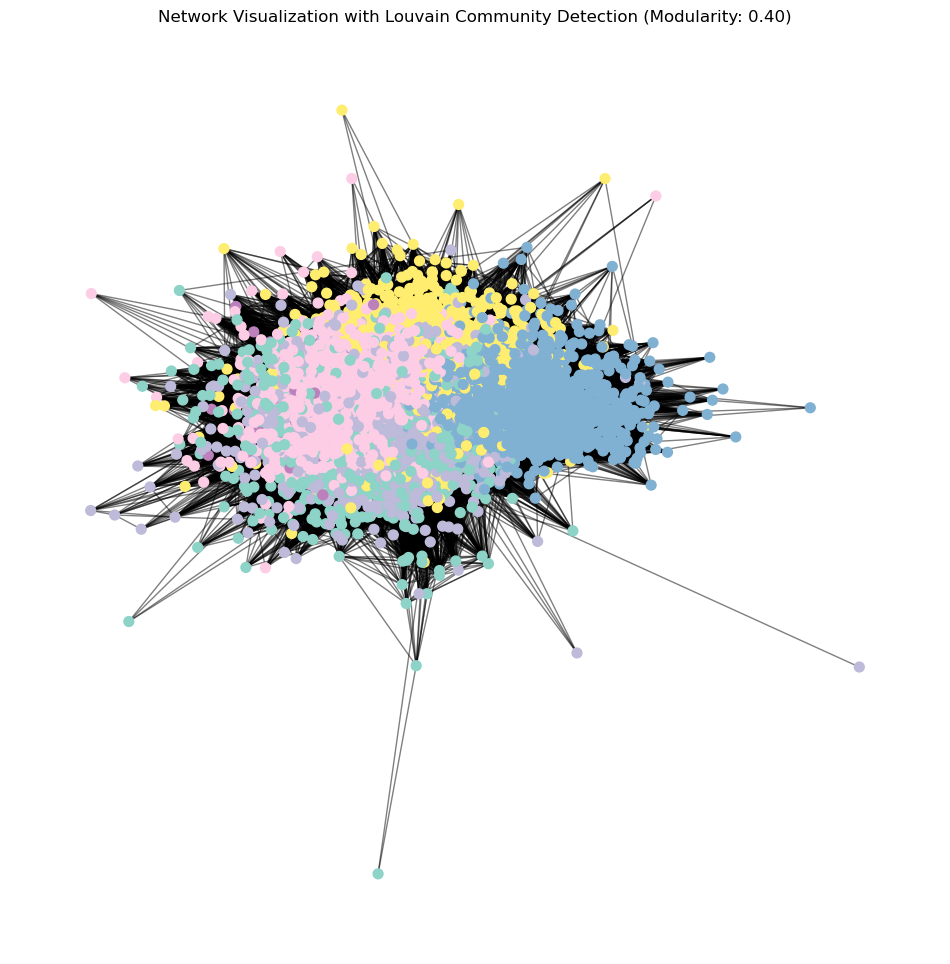

In [36]:


# Assign colors to each community
community_colors = [partition_notexposed[node] for node in G_not_exposed.nodes()]

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_not_exposed)  # Layout for better visualization

nx.draw_networkx_nodes(G_not_exposed, pos, node_color=community_colors, cmap=plt.cm.Set3, node_size=50,label=False)
nx.draw_networkx_edges(G_not_exposed, pos, alpha=0.5)

# Optionally, add labels to nodes
# nx.draw_networkx_labels(G_disruptive, pos,  font_size=8)

plt.title(f"Network Visualization with Louvain Community Detection (Modularity: {modularity_score:.2f})")
plt.savefig('../../results/figures/notexposed_louvain.pdf')
plt.axis('off')
plt.show()


In [24]:
SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE = '/10TBdrive/MJ/Disruptive_Impact_Job/data/Playground07062024/derived/Representative_Task_Not_Impacted/not_exposed_ai_representative_tasks.csv'

In [25]:
finding_representative(G_not_exposed, partition_notexposed  ,tasks_not_exposed_index_to_task, tasks_not_exposed_index_to_index,933,SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE)

Community 0: 'Train other staff, volunteers, or student assistants and schedule and supervise their work.' with degree 1928
Job title 394    Library Technicians
Name: Title, dtype: object
Community size 2568
Job zone 492    3
Name: Job Zone, dtype: int64
NAICS Sector involvement: 10443    Education services
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Provide assistance to faculty and staff in duties such as teaching classes, conducting orientation programs, issuing transcripts, and scheduling events.' with degree 1868
Job title 36    Education Administrators, Postsecondary
Name: Title, dtype: object
Community size 2568
Job zone 252    5
Name: Job Zone, dtype: int64
NAICS Sector involvement: 993    Education services
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Supervise or train students, environmental technologists, technician

In [84]:
SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE = '/10TBdrive/MJ/Disruptive_Impact_Job/data/Playground07062024/derived/Representative_Task_Semantic/not_exposed_ai_representative_tasks2.csv'

In [85]:
finding_representative(G_not_exposed, partition_notexposed  ,tasks_not_exposed_index_to_task, tasks_not_exposed_index_to_index,30,SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE)

Community 0: 'Deliver arrangements to customers, or oversee employees responsible for deliveries.' with degree 1517
Job title 408    Floral Designers
Name: Title, dtype: object
Community size 3173
Job zone 355    2
Name: Job Zone, dtype: int64
NAICS Sector involvement: 10874    Retail trade
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Provide information, technical assistance, or training to supervisors, managers, or employees on topics such as employee supervision, hiring, grievance procedures, or staff development.' with degree 1435
Job title 75    Equal Opportunity Representatives and Officers
Name: Title, dtype: object
Community size 3173
Job zone 293    4
Name: Job Zone, dtype: int64
NAICS Sector involvement: 2118    Education services
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Coordinate with engineers, planners, field p

In [86]:
SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE = '/10TBdrive/MJ/Disruptive_Impact_Job/data/Playground07062024/derived/Representative_Task_Semantic/not_exposed_ai_representative_tasks3.csv'

In [89]:
finding_representative(G_not_exposed, partition_notexposed  ,tasks_not_exposed_index_to_task, tasks_not_exposed_index_to_index,30,SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE)

Community 0: 'Train other staff, volunteers, or student assistants and schedule and supervise their work.' with degree 1952
Job title 394    Library Technicians
Name: Title, dtype: object
Community size 2782
Job zone 492    3
Name: Job Zone, dtype: int64
NAICS Sector involvement: 10443    Education services
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Supervise or train students, environmental technologists, technicians, or other related staff.' with degree 1873
Job title 260    Environmental Scientists and Specialists, Incl...
Name: Title, dtype: object
Community size 2782
Job zone 291    4
Name: Job Zone, dtype: int64
NAICS Sector involvement: Series([], Name: Response, dtype: object)
--------------------------------------------------------------------------------
Community 0: 'Provide assistance to faculty and staff in duties such as teaching classes, conducting orientation programs, issuing transcripts,

In [92]:
SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE = '/10TBdrive/MJ/Disruptive_Impact_Job/data/Playground07062024/derived/Representative_Task_Semantic/not_exposed_ai_representative_tasks4.csv'

In [93]:
finding_representative(G_not_exposed, partition_notexposed  ,tasks_not_exposed_index_to_task, tasks_not_exposed_index_to_index,30,SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE)

Community 4: 'Train other staff, volunteers, or student assistants and schedule and supervise their work.' with degree 1898
Job title 394    Library Technicians
Name: Title, dtype: object
Community size 2568
Job zone 492    3
Name: Job Zone, dtype: int64
NAICS Sector involvement: 10443    Education services
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 4: 'Supervise or train students, environmental technologists, technicians, or other related staff.' with degree 1843
Job title 260    Environmental Scientists and Specialists, Incl...
Name: Title, dtype: object
Community size 2568
Job zone 291    4
Name: Job Zone, dtype: int64
NAICS Sector involvement: Series([], Name: Response, dtype: object)
--------------------------------------------------------------------------------
Community 4: 'Provide assistance to faculty and staff in duties such as teaching classes, conducting orientation programs, issuing transcripts,

In [97]:
SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE = '/10TBdrive/MJ/Disruptive_Impact_Job/data/Playground07062024/derived/Representative_Task_Semantic/not_exposed_ai_representative_tasks5.csv'

In [98]:
finding_representative(G_not_exposed, partition_notexposed  ,tasks_not_exposed_index_to_task, tasks_not_exposed_index_to_index,30,SAVE_NOT_EXPOSED_TASKS_REPRESENTATIVE)

Community 0: 'Deliver arrangements to customers, or oversee employees responsible for deliveries.' with degree 1559
Job title 408    Floral Designers
Name: Title, dtype: object
Community size 3089
Job zone 355    2
Name: Job Zone, dtype: int64
NAICS Sector involvement: 10874    Retail trade
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Provide information, technical assistance, or training to supervisors, managers, or employees on topics such as employee supervision, hiring, grievance procedures, or staff development.' with degree 1440
Job title 75    Equal Opportunity Representatives and Officers
Name: Title, dtype: object
Community size 3089
Job zone 293    4
Name: Job Zone, dtype: int64
NAICS Sector involvement: 2118    Education services
Name: Response, dtype: object
--------------------------------------------------------------------------------
Community 0: 'Coordinate with engineers, planners, field p